#### First Example

In [1]:
import numpy as np
import librosa
import os
import random
import tflearn
import tensorflow as tf

C:\Users\Kunal\Anaconda3\envs\gputest\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
C:\Users\Kunal\Anaconda3\envs\gputest\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
W0604 18:39:41.037695 30968 __init__.py:308] Limited tf.compat.v2.summary API due to missing TensorBoard installation.
W0604 18:39:44.724317 30968 deprecation_wrapper.py:119] From C:\Users\

curses is not supported on this machine (please install/reinstall curses for an optimal experience)


In [2]:
#parameters
lr = 0.001
iterations_train = 30
bsize = 64
audio_features = 20  
utterance_length = 35  
ndigits = 10 

In [3]:
def get_mfcc_features(fpath):
    raw_w,sampling_rate = librosa.load(fpath,mono=True)
    mfcc_features = librosa.feature.mfcc(raw_w,sampling_rate)
    if(mfcc_features.shape[1]>utterance_length):
        mfcc_features = mfcc_features[:,0:utterance_length]
    else:
        mfcc_features=np.pad(mfcc_features,((0,0),(0,utterance_length-mfcc_features.shape[1])), 
                             mode='constant', constant_values=0)
    return mfcc_features

Feature shape:  (20, 35)
Features:  [-5.1646436e+02  2.1872009e+02 -9.4362831e+01  1.6351042e+01
  2.0993744e+01 -4.3879120e+01  1.9426702e+01 -9.4150424e-02
 -2.9996101e+01  1.3972718e+01  6.6056484e-01 -1.1475899e+01
  3.1368847e+00 -1.3455605e+01 -1.4368641e+00  1.1711964e+01
 -1.5449909e+01 -1.1310578e+01  2.5302711e+00 -1.3572546e+01]


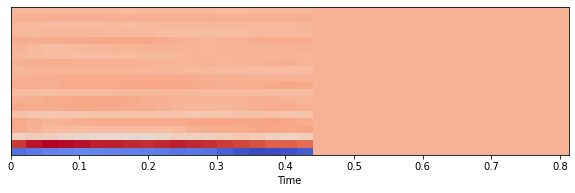

In [4]:
import matplotlib.pyplot as plt
import librosa.display
%matplotlib inline
mfcc_features = get_mfcc_features('./dataset/recordings/train/5_theo_45.wav')
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
librosa.display.specshow(mfcc_features, x_axis='time')
print("Feature shape: ", mfcc_features.shape)
print("Features: ", mfcc_features[:,0])

In [5]:
def get_batch_mfcc(fpath,batch_size=256):
    ft_batch = []
    labels_batch = []
    files = os.listdir(fpath)
    while True:
        print("Total %d files" % len(files))
        random.shuffle(files)
        for fname in files:
            if not fname.endswith(".wav"): 
                continue
            mfcc_features = get_mfcc_features(fpath+fname)  
            label = np.eye(10)[int(fname[0])]
            labels_batch.append(label)
            ft_batch.append(mfcc_features)
            if len(ft_batch) >= batch_size:
                yield ft_batch, labels_batch 
                ft_batch = []  
                labels_batch = []

In [6]:
train_batch = get_batch_mfcc('./dataset/recordings/train/')
sp_network = tflearn.input_data([None, audio_features, utterance_length])
sp_network = tflearn.lstm(sp_network, 128*4, dropout=0.5)
sp_network = tflearn.fully_connected(sp_network, ndigits, activation='softmax')
sp_network = tflearn.regression(sp_network, optimizer='adam', learning_rate=lr, loss='categorical_crossentropy')
sp_model = tflearn.DNN(sp_network, tensorboard_verbose=0)
while iterations_train > 0:
    X_tr, y_tr = next(train_batch)
    X_test, y_test = next(train_batch)
    sp_model.fit(X_tr, y_tr, n_epoch=10, validation_set=(X_test, y_test), show_metric=True, batch_size=bsize)
    iterations_train-=1
sp_model.save("./speech_recognition.lstm")

Training Step: 1199  | total loss: 1.10559 | time: 0.690s
| Adam | epoch: 300 | loss: 1.10559 - acc: 0.7745 -- iter: 192/256
Training Step: 1200  | total loss: 1.02130 | time: 1.953s
| Adam | epoch: 300 | loss: 1.02130 - acc: 0.7970 | val_loss: 0.17620 - val_acc: 0.9688 -- iter: 256/256
--


In [7]:
sp_model.load('./speech_recognition.lstm')
mfcc_features = get_mfcc_features('./dataset/recordings/test/8_theo_21.wav')
mfcc_features = mfcc_features.reshape((1,mfcc_features.shape[0],mfcc_features.shape[1]))
prediction_digit = sp_model.predict(mfcc_features)
print(prediction_digit)
print("Digit predicted: ", np.argmax(prediction_digit))

W0604 19:04:33.333756 30968 deprecation.py:323] From C:\Users\Kunal\Anaconda3\envs\gputest\lib\site-packages\tensorflow\python\training\saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


[[0.07670466 0.01334398 0.04393879 0.01255467 0.00908908 0.05189671
  0.07036389 0.01560096 0.6555225  0.05098466]]
Digit predicted:  8
